In [24]:
import random
from dataclasses import dataclass, field
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
@dataclass
class Process:
    pid: int
    arrival: int
    burst: int
    priority: int = 0
    extra: dict = field(default_factory=dict)

def gerar_processos(n=10,
                    max_arrival=20,
                    min_burst=1, max_burst=10,
                    min_prio=1, max_prio=5):
    processos = []
    for pid in range(n):
        p = Process(
            pid=pid,
            arrival=random.randint(0, max_arrival),
            burst=random.randint(min_burst, max_burst),
            priority=random.randint(min_prio, max_prio)
        )
        processos.append(p)

    processos.sort(key=lambda p: p.arrival)
    return processos

In [26]:
def scheduler_fcfs(ready_queue, core_proc, tempo):
    if core_proc is not None and core_proc["remaining"] > 0:
        return core_proc, ready_queue

    if not ready_queue:
        return None, ready_queue

    proc = ready_queue.pop(0)

    if proc["start_time"] is None:
        proc["start_time"] = tempo
        proc["response_time"] = tempo - proc["arrival"]

    return proc, ready_queue

In [27]:
def scheduler_sjf_preemptivo(ready_queue, core_proc, tempo):
    if core_proc is not None and core_proc["remaining"] > 0:
        if core_proc not in ready_queue:
            ready_queue.append(core_proc)

    if not ready_queue:
        return None, ready_queue

    ready_queue.sort(key=lambda p: p["remaining"])
    proc = ready_queue.pop(0)

    if proc["start_time"] is None:
        proc["start_time"] = tempo
        proc["response_time"] = tempo - proc["arrival"]

    return proc, ready_queue


In [28]:
def scheduler_prioridade(ready_queue, core_proc, tempo):
    if core_proc is not None and core_proc["remaining"] > 0:
        if core_proc not in ready_queue:
            ready_queue.append(core_proc)

    if not ready_queue:
        return None, ready_queue

    ready_queue.sort(key=lambda p: p["priority"])
    proc = ready_queue.pop(0)

    if proc["start_time"] is None:
        proc["start_time"] = tempo
        proc["response_time"] = tempo - proc["arrival"]

    return proc, ready_queue

In [44]:
def scheduler_mlfq(ready_queue, core_proc, tempo):
    if core_proc is not None:
        core_proc.setdefault("nivel", 0)
        core_proc.setdefault("quantum_restante", 0)
    for p in ready_queue:
        p.setdefault("nivel", 0)
        p.setdefault("quantum_restante", 0)

    if (
        core_proc is not None
        and core_proc["remaining"] > 0
        and core_proc["quantum_restante"] > 0
    ):
        core_proc["quantum_restante"] -= 1
        return core_proc, ready_queue

    if core_proc is not None and core_proc["remaining"] <= 0:
        return None, ready_queue

    if core_proc is not None and core_proc["quantum_restante"] <= 0:
        if core_proc["nivel"] < 2:
            core_proc["nivel"] += 1
        ready_queue.append(core_proc)

    if not ready_queue:
        return None, ready_queue

    ready_queue.sort(key=lambda p: (p.get("nivel", 0), p["arrival"]))
    proc = ready_queue.pop(0)

    if proc.get("start_time") is None:
        proc["start_time"] = tempo
        proc["response_time"] = tempo - proc["arrival"]


    nivel = proc.get("nivel", 0)
    if nivel == 0:
        proc["quantum_restante"] = 2
    elif nivel == 1:
        proc["quantum_restante"] = 4
    else:
        proc["quantum_restante"] = 999999

    return proc, ready_queue

In [45]:
def scheduler_rr(ready_queue, core_proc, tempo, state):
    cid = state["cid"]
    quantum = state["quantum"]
    quantum_restante = state["quantum_restante"]

    atual = core_proc

    if atual is None or quantum_restante[cid] <= 0 or atual["remaining"] <= 0:

        if atual is not None and atual["remaining"] > 0:
            ready_queue.append(atual)

        if not ready_queue:
            quantum_restante[cid] = 0
            return None, ready_queue

        proc = ready_queue.pop(0)
        if proc["start_time"] is None:
            proc["start_time"] = tempo
            proc["response_time"] = tempo - proc["arrival"]

        quantum_restante[cid] = quantum
        return proc, ready_queue

    return atual, ready_queue

In [46]:
UNIDADE_TEMPO = "ms"

In [47]:
def simular(processos, algoritmo, n_cores=1, quantum=4,
            salvar_timeline=True, max_tempo=100000):

    procs = []
    for p in processos:
        d = {
            "pid": p.pid,
            "arrival": p.arrival,
            "burst": p.burst,
            "remaining": p.burst,
            "priority": getattr(p, "priority", 0),
            "start_time": None,
            "completion_time": None,
            "response_time": None,
        }
        d.setdefault("nivel", 0)
        d.setdefault("quantum_restante", 0)
        procs.append(d)

    tempo = 0
    cores = [None] * n_cores
    ready_queue = []
    quantum_restante = [0] * n_cores
    timeline = [] if salvar_timeline else None

    def adicionar_chegados():
        for proc in procs:
            if proc["arrival"] == tempo:
                ready_queue.append(proc)


    schedulers = {
        "fcfs": scheduler_fcfs,
        "sjf_preemptivo": scheduler_sjf_preemptivo,
        "prioridade": scheduler_prioridade,
        "mlfq": scheduler_mlfq,
    }

    while any(p["remaining"] > 0 for p in procs) and tempo < max_tempo:

        adicionar_chegados()

        for cid in range(n_cores):
            atual = cores[cid]

            if atual is not None and atual["remaining"] <= 0 and atual["completion_time"] is None:
                atual["completion_time"] = tempo
                cores[cid] = None
                atual = None

            if algoritmo == "rr":
                atual, ready_queue = scheduler_rr(
                    ready_queue,
                    atual,
                    tempo,
                    {"cid": cid,
                     "quantum": quantum,
                     "quantum_restante": quantum_restante},
                )
            else:
                atual, ready_queue = schedulers[algoritmo](ready_queue, atual, tempo)

            cores[cid] = atual

            if atual is not None:
                atual["remaining"] -= 1
                if algoritmo == "rr":
                    quantum_restante[cid] -= 1

            if salvar_timeline:
                timeline.append({
                    "tempo": tempo,
                    "core": cid,
                    "pid": atual["pid"] if atual is not None else None
                })

        tempo += 1

    if tempo >= max_tempo:
        print("⚠ Atenção: atingiu max_tempo, possivelmente há bug no algoritmo.")

    for p in procs:
        if p["remaining"] <= 0 and p["completion_time"] is None:
            p["completion_time"] = tempo

    return procs, timeline

In [48]:
def calcular_context_switches(timeline, n_cores):
    prev_pid = {cid: None for cid in range(n_cores)}
    context_switches = 0

    for entry in timeline:
        cid = entry["core"]
        pid = entry["pid"]
        last = prev_pid[cid]

        if last != pid:
            if last is not None:
                context_switches += 1
        prev_pid[cid] = pid

    return context_switches

In [49]:
def calcular_cpu_utilization(timeline, n_cores):
    total_slots = len(timeline)
    busy_slots = sum(1 for e in timeline if e["pid"] is not None)

    if total_slots == 0:
        return 0.0

    utilizacao = busy_slots / total_slots
    return utilizacao * 100.0


In [50]:
def calcular_metricas(procs, timeline, n_cores):
    df = pd.DataFrame(procs)
    df["turnaround"] = df["completion_time"] - df["arrival"]
    df["waiting"] = df["turnaround"] - df["burst"]
    df["response"] = df["response_time"]

    tempo_total = max(timeline, key=lambda x: x["tempo"])["tempo"] + 1

    throughput = len(df) / tempo_total

    context_switches = calcular_context_switches(timeline, n_cores)
    cpu_util = calcular_cpu_utilization(timeline, n_cores)

    medias = {
        "waiting_medio": df["waiting"].mean(),
        "turnaround_medio": df["turnaround"].mean(),
        "response_medio": df["response"].mean(),
        "throughput": throughput,
        "tempo_total": tempo_total,
        "context_switches": context_switches,
        "cpu_utilizacao": cpu_util,   # em %
    }
    return df, medias

In [51]:
def curva_processos_concluidos(procs):
    tempo_max = max(p["completion_time"] for p in procs)
    xs = list(range(tempo_max + 1))
    ys = []

    for t in xs:
        concluidos = sum(
            1 for p in procs
            if p["completion_time"] is not None and p["completion_time"] <= t
        )
        ys.append(concluidos)

    return xs, ys

In [52]:
def comparar_algoritmos(processos, algoritmos, n_cores=1, quantum=4):
    resultados = []
    curvas = {}

    for alg in algoritmos:
        procs_sim, timeline = simular(processos, alg, n_cores=n_cores, quantum=quantum)
        df, medias = calcular_metricas(procs_sim, timeline, n_cores)
        resultados.append({"algoritmo": alg, **medias})

        xs, ys = curva_processos_concluidos(procs_sim)
        curvas[alg] = {
            "tempo": xs,
            "concluidos": ys,
            "tempo_final": xs[-1],
        }

    df_res = pd.DataFrame(resultados)
    return df_res, curvas

In [53]:
def plot_curva_por_escalonador(curvas):
    for alg, curva in curvas.items():
        xs = curva["tempo"]
        ys = curva["concluidos"]

        plt.figure(figsize=(9, 4))
        plt.plot(xs, ys, marker="o", linestyle="-", linewidth=2)

        plt.xlabel(f"Tempo ({UNIDADE_TEMPO})")
        plt.ylabel("Processos concluídos")
        plt.title(f"Progresso da simulação — {alg.upper()}")
        plt.grid(True, linestyle="--", alpha=0.5)

        plt.text(xs[-1], ys[-1],
                 f" fim: {xs[-1]} {UNIDADE_TEMPO}",
                 fontsize=9, va="center")

        plt.tight_layout()
        plt.show()

In [54]:
def plot_tempo_medio_espera(df_res):
    plt.figure(figsize=(8, 4))

    x = range(len(df_res))
    y = df_res["waiting_medio"]
    labels = df_res["algoritmo"]

    plt.bar(x, y)
    plt.xticks(x, labels)
    plt.ylabel("Tempo médio de espera (ms)")
    plt.xlabel("Algoritmo de escalonamento")
    plt.title("Comparação do tempo médio de espera entre algoritmos")

    for i, v in enumerate(y):
        plt.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [55]:
def plot_tempo_total(df_res):
    plt.figure(figsize=(8, 4))

    x = range(len(df_res))
    y = df_res["tempo_total"]
    labels = df_res["algoritmo"]

    plt.bar(x, y)
    plt.xticks(x, labels)
    plt.ylabel("Tempo total de simulação (ms)")
    plt.xlabel("Algoritmo de escalonamento")
    plt.title("Tempo total de execução por algoritmo")

    for i, v in enumerate(y):
        plt.text(i, v, f"{v:.0f}", ha="center", va="bottom")

    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [56]:
def plot_context_switches(df_res):
    plt.figure(figsize=(8, 4))

    x = range(len(df_res))
    y = df_res["context_switches"]
    labels = df_res["algoritmo"]

    plt.bar(x, y)
    plt.xticks(x, labels)
    plt.ylabel("Trocas de contexto (unidades)")
    plt.xlabel("Algoritmo de escalonamento")
    plt.title("Trocas de contexto por algoritmo")

    for i, v in enumerate(y):
        plt.text(i, v, f"{v:.0f}", ha="center", va="bottom")

    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

In [57]:
def plot_cpu_utilizacao(df_res):
    plt.figure(figsize=(8, 4))

    x = range(len(df_res))
    y = df_res["cpu_utilizacao"]
    labels = df_res["algoritmo"]

    plt.bar(x, y)
    plt.xticks(x, labels)
    plt.ylabel("Utilização da CPU (%)")
    plt.xlabel("Algoritmo de escalonamento")
    plt.title("Utilização média da CPU por algoritmo")

    for i, v in enumerate(y):
        plt.text(i, v, f"{v:.1f}%", ha="center", va="bottom")

    plt.ylim(0, max(y)*1.15 if len(y) > 0 else 1)
    plt.grid(axis="y", linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()


In [65]:
processos = gerar_processos(15)
algoritmos = ["fcfs", "rr", "sjf_preemptivo", "prioridade", "mlfq"]

df_res, curvas = comparar_algoritmos(processos, algoritmos, n_cores=2, quantum=3)
display(df_res)

,algoritmo,waiting_medio,turnaround_medio,response_medio,throughput,tempo_total,context_switches,cpu_utilizacao
0,fcfs,13.933333,20.266667,13.933333,0.306122,49,14,96.938776
1,rr,21.466667,27.800000,6.133333,0.306122,49,36,96.938776
2,sjf_preemptivo,10.200000,16.533333,6.800000,0.300000,50,19,95.000000
3,prioridade,15.266667,21.600000,11.000000,0.294118,51,46,93.137255
4,mlfq,22.400000,28.733333,3.800000,0.312500,48,30,98.958333


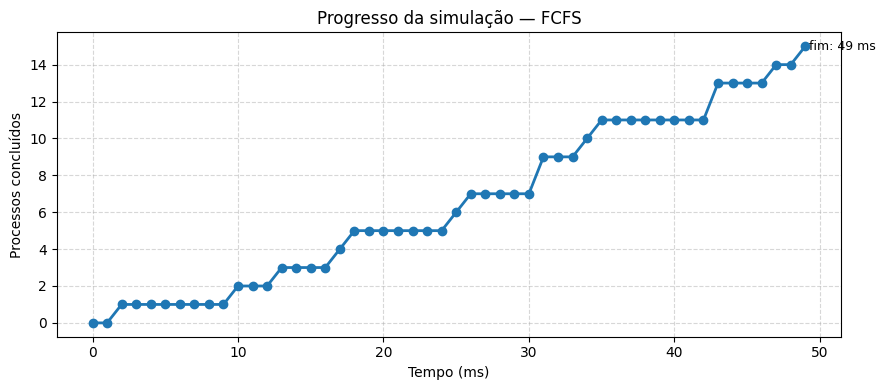

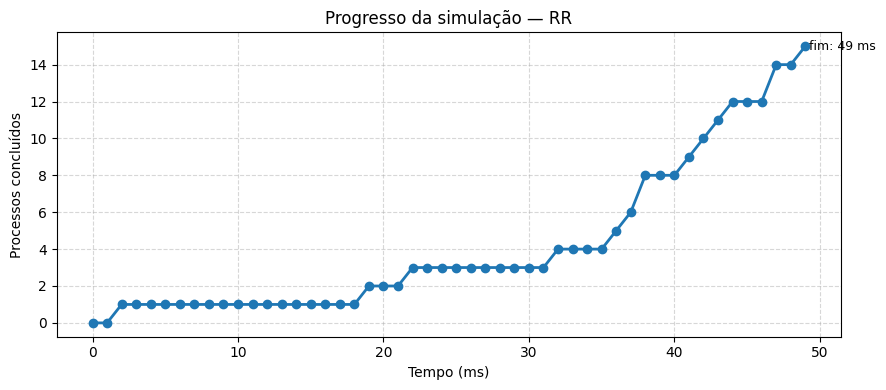

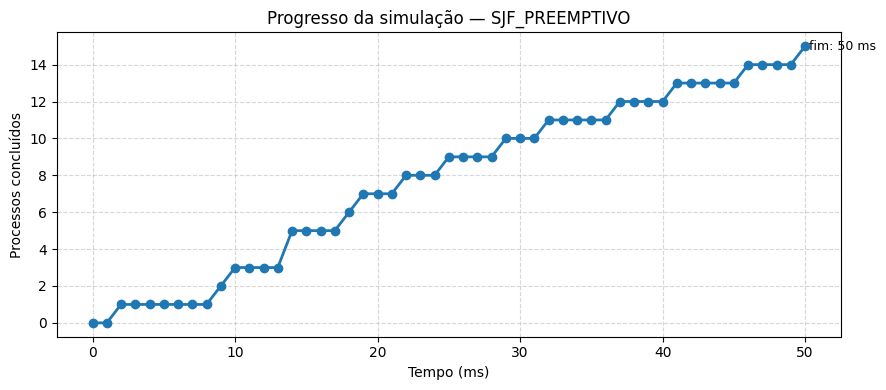

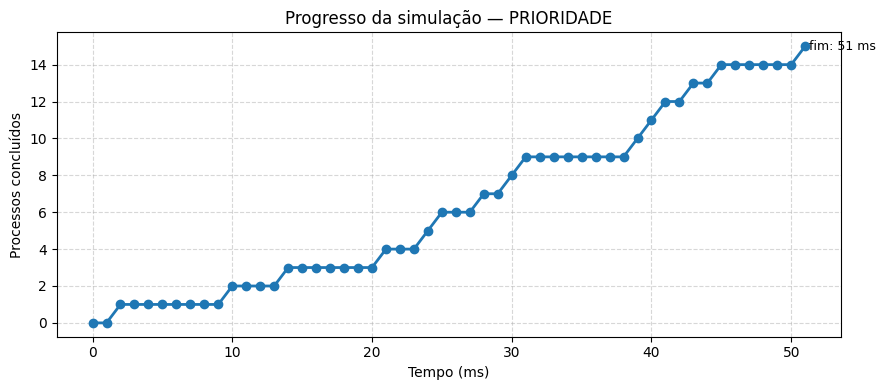

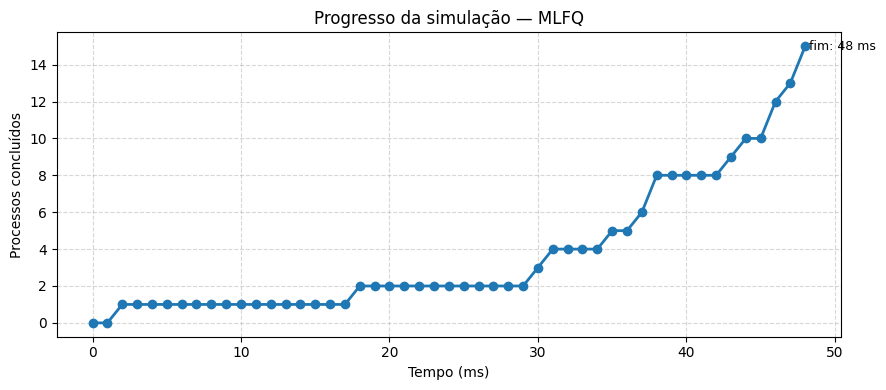

In [66]:
plot_curva_por_escalonador(curvas)

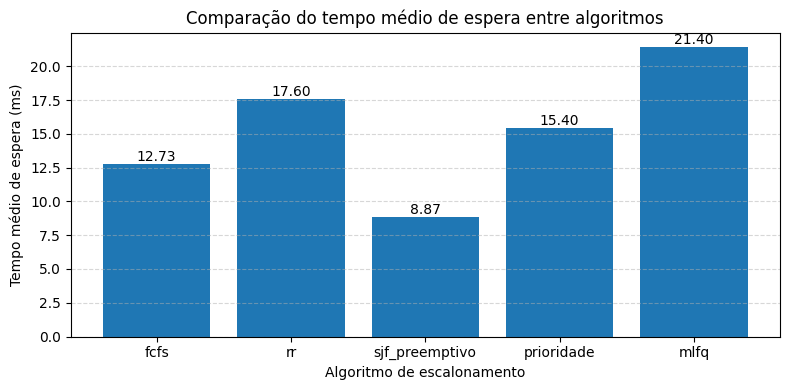

In [59]:
plot_tempo_medio_espera(df_res)

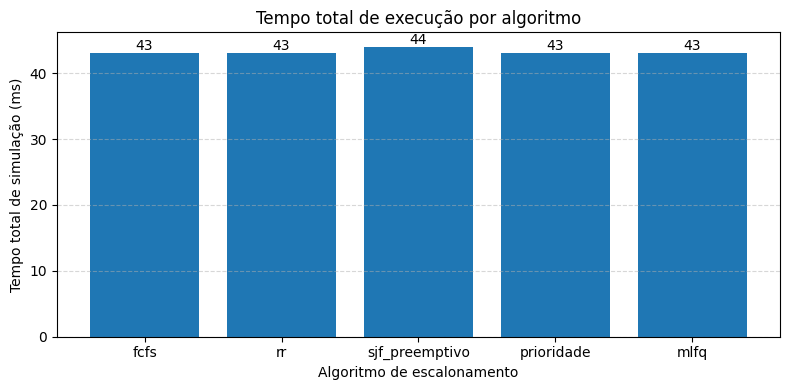

In [64]:
plot_tempo_total(df_res)

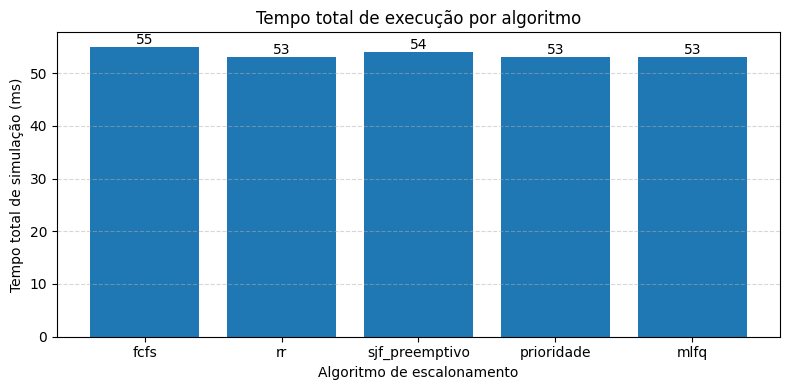

In [60]:
plot_tempo_total(df_res)

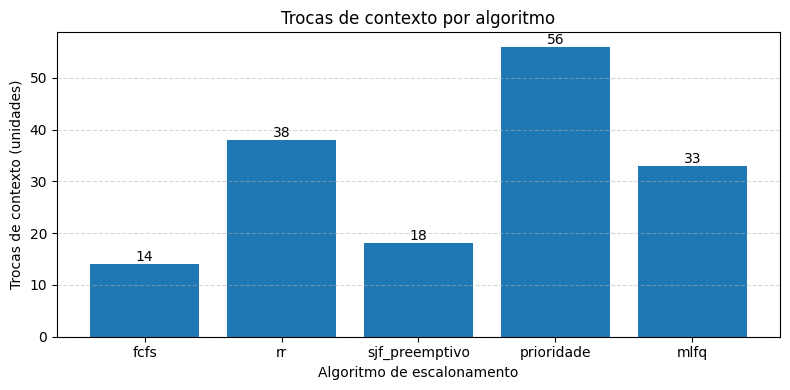

In [61]:
plot_context_switches(df_res)

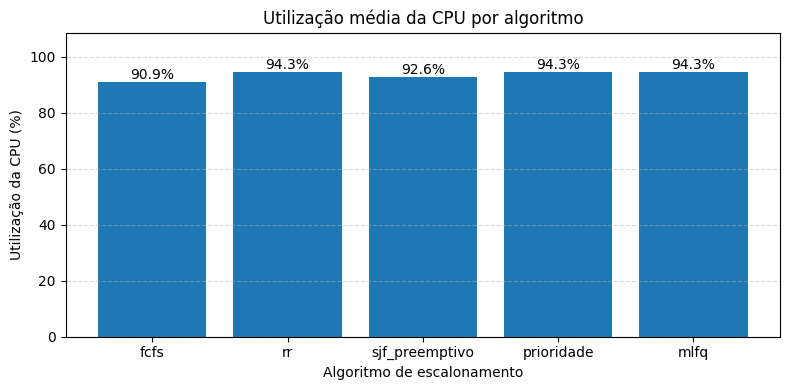

In [62]:
plot_cpu_utilizacao(df_res)